In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%%bash
uname -a
whoami

edmFileUtil root://eoscms.cern.ch///store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/C0D83139-4A6E-E711-B1A9-02163E0137FC.root
edmFileUtil root://eoscms.cern.ch///store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/4269D74E-4A6E-E711-847B-02163E01A487.root

Linux vinavx3.cern.ch 3.10.0-514.10.2.el7.x86_64 #1 SMP Fri Mar 3 00:04:05 UTC 2017 x86_64 x86_64 x86_64 GNU/Linux
innocent
root://eoscms.cern.ch///store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/C0D83139-4A6E-E711-B1A9-02163E0137FC.root
root://eoscms.cern.ch///store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/C0D83139-4A6E-E711-B1A9-02163E0137FC.root (1 runs, 1 lumis, 1522 events, 2449095209 bytes)
root://eoscms.cern.ch///store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/4269D74E-4A6E-E711-847B-02163E01A487.root
root://eoscms.cern.ch///store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/4269D74E-4A6E-E711-847B-02163E01A487.root (1 runs, 3 lumis, 4077 events, 2088712010 bytes)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import time
from multiprocessing import Pool
from DataFormats.FWLite import Handle, Events

Welcome to JupyROOT 6.10/01


In [4]:
xrd = 'root://cms-xrd-global.cern.ch//'
tier0 = 'root://cms-xrd-tzero.cern.ch//' # 'file:/eos/cms/tier0'
tier2 = 'root://eoscms.cern.ch//' #'file:/eos/cms'
myTracking = 'root://eoscms.cern.ch///store/group/phys_tracking/vincenzo/run2017/'

def mc() :
    files = [\
    '/store/relval/CMSSW_9_3_0_pre2/RelValTTbar_13/GEN-SIM-RECO/PU25ns_92X_upgrade2017_realistic_v7-v1/00000/4C90EDAC-3169-E711-94DA-0CC47A7452D0.root',\
            ]
    return map(lambda x : xrd+x,files)


def oldStuff() :
    files = [\
    '/store/data/Run2016H/JetHT/AOD/PromptReco-v2/000/283/408/00000/AE49FDAB-8398-E611-9B98-02163E014388.root',\
    '/store/data/Run2016H/JetHT/AOD/PromptReco-v2/000/283/408/00000/88FB6BA5-7B98-E611-B25E-FA163EE1CC08.root',\
    '/store/data/Run2017B/SingleMuon/AOD/PromptReco-v2/000/299/061/00000/5C4984B0-B86A-E711-837F-02163E01A792.root',
    '/store/data/Run2017B/SingleMuon/AOD/PromptReco-v2/000/299/067/00000/B4146406-F66A-E711-B9C9-02163E014389.root',\
            ]
    return map(lambda x : xrd+x,files)


def jetHT2017C() :
    files = [\
    '/store/data/Run2017C/JetHT/AOD/PromptReco-v1/000/299/443/00000/7C92F761-A270-E711-90A8-02163E014506.root',\
    '/store/data/Run2017C/JetHT/AOD/PromptReco-v1/000/299/649/00000/D0BA6C4A-DB71-E711-99BC-02163E013910.root',\
    '/store/data/Run2017C/JetHT/AOD/PromptReco-v1/000/299/592/00000/44735821-ED70-E711-A9F3-02163E019C7D.root',\
    '/store/data/Run2017C/JetHT/AOD/PromptReco-v1/000/299/478/00000/7C39B1F9-A970-E711-AC40-02163E0138D5.root',\
    '/store/data/Run2017C/JetHT/AOD/PromptReco-v1/000/299/480/00000/9276CDF3-B870-E711-9878-02163E019D8F.root',\
    #'/store/data/Run2017C/JetHT/AOD/PromptReco-v1/000/299/478/00000/E2BB4D9E-A870-E711-8684-02163E0142DF.root',\
    #'/store/data/Run2017C/JetHT/AOD/PromptReco-v1/000/299/420/00000/5EC981C1-426E-E711-9C05-02163E0135F2.root',\
            ]
    return map(lambda x : tier0+x,files)
    
def express2017C() :
    files = [\
    '/store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/592/00000/1482C818-456E-E711-A4AC-02163E01A3E1.root',\
    '/store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/4CA2B934-716E-E711-B4F0-02163E01A3E5.root',\
    '/store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/523D4165-4A6E-E711-B186-02163E012A87.root',\
    '/store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/C0D83139-4A6E-E711-B1A9-02163E0137FC.root',\
    '/store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/C6AE7442-4A6E-E711-864C-02163E019D7E.root',\
    '/store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/4269D74E-4A6E-E711-847B-02163E01A487.root',\
    '/store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/2449BE69-4A6E-E711-BCD5-02163E0128FE.root',\
    '/store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/9C51DE1E-4A6E-E711-9701-02163E019E83.root',\
    '/store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/649/00000/28D1AE00-2170-E711-96CA-02163E019D3B.root'\
    ]
    return map(lambda x : tier2+x,files)

def myFiles() :
    files = [\
             'JetHT_reco299592.root',\
             'JetHT_tkreco299592.root',\
             ]
    return map(lambda x : myTracking+x,files)

In [5]:
label = "generalTracks"
quality = "highPurity"

In [6]:
def runid(event,lumi) :
    id = event.object().id()
    a=event.getByLabel('scalersRawToDigi', lumi)
    return '{:d}:{:d}:{:.2e}'.format(int(id.run()),int(id.luminosityBlock()),\
                                     lumi.product()[0].instantLumi() if not lumi.product().empty() else 0)
def skip2Lumi(events,ls):
    for i in range(0,events.size()):
        a= events.to(i)
        id = events.object().id()
        if (int(id.luminosityBlock())==ls) : return i
    return events.size()

In [7]:
def loadTk(events,tracks,vertices, fe) :
    tkParsA = []
    tkHitsA = []
    for i in range(fe,events.size()):
      if (len(tkParsA) > 1000000) : break
      a= events.to(i)
      if (i%1000==0) : 
        id = events.object().id()
        evid = '{:d}:{:d}:{:d}'.format(int(id.run()),int(id.luminosityBlock()), int(id.event()))
        print "Event", i , evid
      a=events.getByLabel(label, tracks)
      a=events.getByLabel("offlinePrimaryVertices",vertices)
      pv = vertices.product()[0]
      if (not pv.isValid()) : continue
      pvp = pv.position()
      for tk in tracks.product() :
        if (not tk.quality(tk.qualityByName(quality))) : continue
        if (tk.pt()<0.7) : continue
        if (abs(tk.dz(pvp))>0.5) : continue # only PV tracks
        pattern = tk.hitPattern()
        if (pattern.numberOfValidHits()<8) : continue
        if (pattern.numberOfValidPixelHits()<1) : continue
        tkParsA.append([tk.eta(),tk.phi(),tk.pt(),\
                        tk.dxy(pvp),tk.dxyError(), tk.dz(pvp), tk.dzError(),\
                        pattern.numberOfValidHits(),pattern.numberOfValidPixelHits(),tk.ndof(),tk.chi2(),tk.originalAlgo()-4])
        tkHitsA.append([pattern.getTrackerLayerCase(0,1,1), pattern.getTrackerLayerCase(1,1,1),\
                        pattern.getTrackerLayerCase(0,1,2), pattern.getTrackerLayerCase(1,1,2),\
                        pattern.getTrackerLayerCase(0,2,1), pattern.getTrackerLayerCase(1,2,1)])

    print len(tkParsA)
    tkPars = np.array(zip(*tkParsA), dtype=np.float)
    print len(tkPars)
    tkHits = np.array(zip(*tkHitsA), np.int32)
    print len(tkHits)
    return tkPars,tkHits

In [8]:
def loadFile(name) :
    loaded = np.load('/tmp/'+name+'.npz')
    runid = loaded['arr_0']
    n = len(runid)
    tkPars = [loaded['arr_'+str(i+1)] for i in range(0,n)]
    tkHits = [loaded['arr_'+str(i+1+n)] for i in range(0,n)]
    return runid,tkPars,tkHits
def saveFile(name,runid,tkPars,tkHits) :
    np.savez_compressed('/tmp/'+name,runid,*(tkPars+tkHits))

In [9]:
def processIt(fevents) :
    print fevents
    events = Events(fevents)
    tracks = Handle("std::vector<reco::Track>")
    lumi = Handle("std::vector<LumiScalers>")
    vertices = Handle("vector<reco::Vertex>")
    a= events.to(0)
    ls = int(events.object().id().luminosityBlock())
    if (ls==103) : ls=105
    fe = skip2Lumi(events,ls)
    a= events.to(fe)
    runid0 = runid(events,lumi)
    print runid0
    tkPars, tkHits = loadTk(events,tracks,vertices,fe)
    runidl = runid(events,lumi)
    print runidl
    return (runid0+'-->'+runidl, tkPars, tkHits)

In [25]:
def readAOD(files) :
    p = Pool(4)
    t = -time.time()
    ret = p.map(processIt,files)
    t +=time.time()
    print t
    runid0, tkPars, tkHits = zip(*ret)
    print runid0
    print len(tkHits)
    p.terminate()
    return runid0, tkPars, tkHits

In [26]:
files = oldStuff() # jetHT2017C() + mc() # jetHT2017C() # express2017C() # myFiles() # oldStuff() #
t = -time.time()
fromAOD = True
runid0, tkPars, tkHits = readAOD(files) if fromAOD else loadFile('jetHT2017C')
t +=time.time()
print 'time to read', t
print len(tkHits)

root://cms-xrd-global.cern.ch///store/data/Run2017B/SingleMuon/AOD/PromptReco-v2/000/299/061/00000/5C4984B0-B86A-E711-837F-02163E01A792.root
root://cms-xrd-global.cern.ch///store/data/Run2017B/SingleMuon/AOD/PromptReco-v2/000/299/067/00000/B4146406-F66A-E711-B9C9-02163E014389.root
root://cms-xrd-global.cern.ch///store/data/Run2016H/JetHT/AOD/PromptReco-v2/000/283/408/00000/AE49FDAB-8398-E611-9B98-02163E014388.root
root://cms-xrd-global.cern.ch///store/data/Run2016H/JetHT/AOD/PromptReco-v2/000/283/408/00000/88FB6BA5-7B98-E611-B25E-FA163EE1CC08.root
283408:999:8.97e+03
283408:50:1.43e+04
Event 0 283408:999:1691761305
Event 0 283408:50:73504492
299061:71:1.20e+04
Event 0 299061:71:43248274
299067:23:7.98e+03
Event 0 299067:23:26929302
Event 1000 283408:999:1690577203
Event 1000 283408:50:72985322
Event 2000 283408:999:1691756358
Event 2000 283408:50:73340182
Event 3000 283408:1000:1693722309
Event 4000 283408:1000:1693290483
Event 3000 283408:50:72215874
Event 5000 283408:1001:1694240933


In [27]:
t = -time.time()
if fromAOD :
    saveFile('oldStuff',runid0, tkPars, tkHits)
t += time.time()
print 'time to write',t
print len(tkHits)

time to write 6.79424715042
4


In [28]:
%%bash
ls -l /tmp/*.npz

-rw-r--r--. 1 innocent zh 206010328 Jul 29 19:03 /tmp/bha.npz
-rw-r--r--. 1 innocent zh  29809997 Jul 29 17:46 /tmp/events2017B_LL.npz
-rw-r--r--. 1 innocent zh 208609745 Jul 30 10:06 /tmp/jetHT2017C.npz
-rw-r--r--. 1 innocent zh 137014322 Jul 30 10:52 /tmp/oldStuff.npz


In [29]:
#loaded = np.load('/tmp/bha.npz')

In [30]:
#dict(loaded)

In [31]:
def corr(tkPars) :
    print len(tkPars)
    print np.corrcoef(tkPars)
#map(corr,tkPars)

In [32]:
def eff(var,tkPars,tkHits) :
    hp = np.greater(tkPars[2],4.0)
    pv = np.less(abs(tkPars[5]),0.1) # &np.less(abs(tkPars[3]),0.01)
    valL2 = np.equal(tkHits[2],0)
    valF1 = np.equal(tkHits[4],0)
    hp = hp&(valL2)&pv # |valF1)
    nbins = 62
    yv,x = np.histogram(tkPars[var],np.linspace(-3.1,3.1,nbins),weights=1.*hp*np.equal(tkHits[0],0)) 
    yl,x = np.histogram(tkPars[var],np.linspace(-3.1,3.1,nbins),weights=1.*hp*np.equal(tkHits[0],1)) 
    #yi,x = np.histogram(tkPars[var],np.linspace(-3.1,3.1,nbins),weights=1.*hp*np.equal(tkHits[0],2)) 
    ym,x = np.histogram(tkPars[var],np.linspace(-3.1,3.1,nbins),weights=1.*hp*np.equal(tkHits[1],1)) 
    ya=yv+ym # +yl
    # y2,x = np.histogram(tkPars[var],np.linspace(-3.1,3.1,nbins),weights=1.*hp)
    x.resize(len(yv))
    return x,yv/ya

In [33]:
from scipy.stats import norm
import numpy.ma as ma
def sip(var,tkPars,tkHits) :
    hp = np.greater(tkPars[2],4.0)
    pvz = np.less(abs(tkPars[5]),0.1)
    pvt = np.less(abs(tkPars[3]),0.05)
    valL1 = np.equal(tkHits[0],0)
    valL2 = np.equal(tkHits[2],0)
    valF1 = np.equal(tkHits[4],0)
    hp1 = hp&(valL1)
    hp2 = hp&((valL2) & np.logical_not(valL1))
    
    nbins = 62
    ye1,vx = np.histogram(tkPars[var],np.linspace(-3.1,3.1,nbins),weights=tkPars[4]*hp1*pvz)
    ye2,vx = np.histogram(tkPars[var],np.linspace(-3.1,3.1,nbins),weights=tkPars[4]*hp2*pvz)
    ya1,vx = np.histogram(tkPars[var],np.linspace(-3.1,3.1,nbins),weights=1.*hp1*pvz)
    ya2,vx = np.histogram(tkPars[var],np.linspace(-3.1,3.1,nbins),weights=1.*hp2*pvz)

    vx.resize(len(ye2))


    nbins = 100
    yt1,x = np.histogram(tkPars[3]/tkPars[4],np.linspace(-10.,10.,nbins),weights=1.*hp1*pvz,density=True)
    masked = ma.masked_where(~(hp1&pvz),ma.masked_outside(tkPars[3]/tkPars[4],-2.5,2.5))
    print 'dxy with L1',norm.fit(masked[~masked.mask])
    yz1,x = np.histogram(tkPars[5]/tkPars[6],np.linspace(-10.,10.,nbins),weights=1.*hp1*pvt,density=True) 
    yt2,x = np.histogram(tkPars[3]/tkPars[4],np.linspace(-10.,10.,nbins),weights=1.*hp2*pvz,density=True) 
    masked = ma.masked_where(~(hp2&pvz),ma.masked_outside(tkPars[3]/tkPars[4],-2.5,2.5))
    print 'dxy w/o L1', norm.fit(masked[~masked.mask])
    yz2,x = np.histogram(tkPars[5]/tkPars[6],np.linspace(-10.,10.,nbins),weights=1.*hp2*pvt,density=True)
    x.resize(len(yt1))
    return x,yt1,yz1,yt2,yz2,vx,ye1/ya1,ye2/ya2    

In [34]:
eta=0
phi=1
pt=2

In [35]:
effH = map(eff,[phi]*len(tkPars),tkPars, tkHits)
print len(effH)

4


In [36]:
sipH = map(sip,[eta]*len(tkPars),tkPars, tkHits)
print len(sipH)

dxy with L1 (0.029430537989051524, 1.0383345792383749)
dxy w/o L1 (0.056138843652588172, 1.0525680677272589)


/cvmfs/cms.cern.ch/slc7_amd64_gcc630/external/py2-pippkgs/5.0-ghjeda2/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in divide


dxy with L1 (-0.00042945253049462651, 1.001147890654378)
dxy w/o L1 (0.072163825952911112, 1.0435301454361292)
dxy with L1 (-0.044962989847906074, 0.87240009810033747)
dxy w/o L1 (-0.025573626359350579, 0.90071041368983673)
dxy with L1 (-0.05077614311916754, 0.85929048843876232)
dxy w/o L1 (-0.078939104524132067, 0.90499643140481489)
4


In [37]:
from scipy.optimize import leastsq
fitfunc  = lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/p[2])**2) # +p[3]
errfunc  = lambda p, x, y: (y - fitfunc(p, x))  #   /np.sqrt(np.clip(y,a_min=0.00001,a_max=None))
init  = [0.5, 0.0, 1.0] # , 0.5]

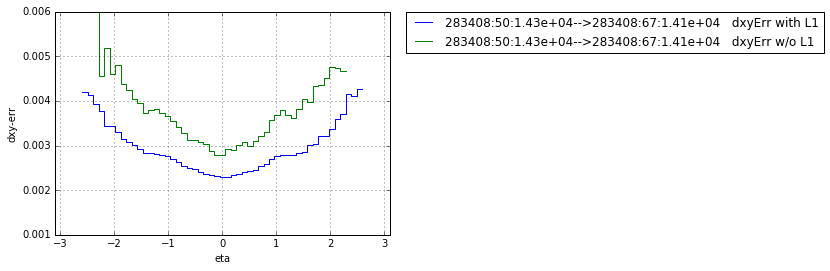

[ 0.32966584 -0.06835475  1.11889394]
[ 0.31887152 -0.02500491  1.15509851]


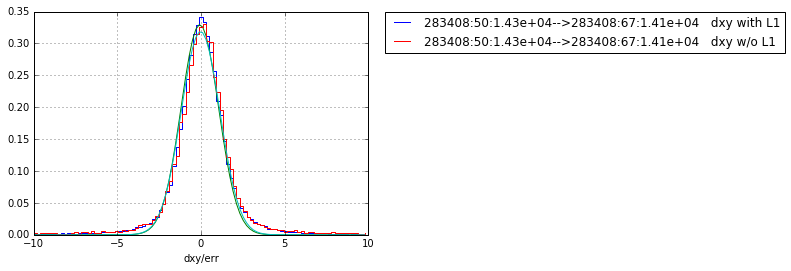

[ 0.32733954 -0.09417818  1.10582231]
[ 0.32531285 -0.10340113  1.14373256]


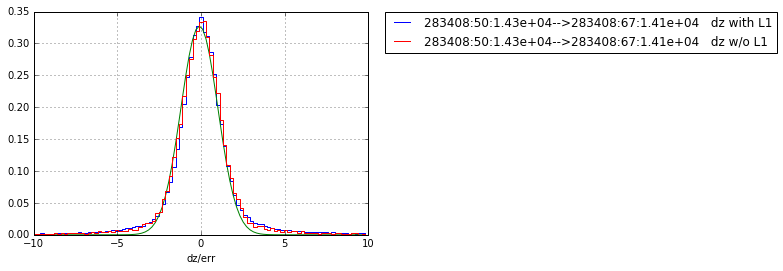

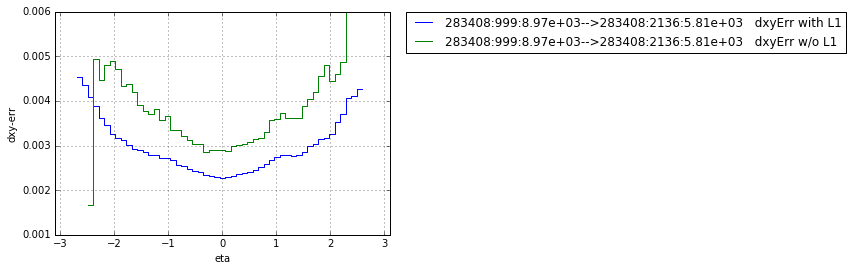

[ 0.35466653 -0.10203071  1.05275375]
[ 0.31894389 -0.01125189  1.13864301]


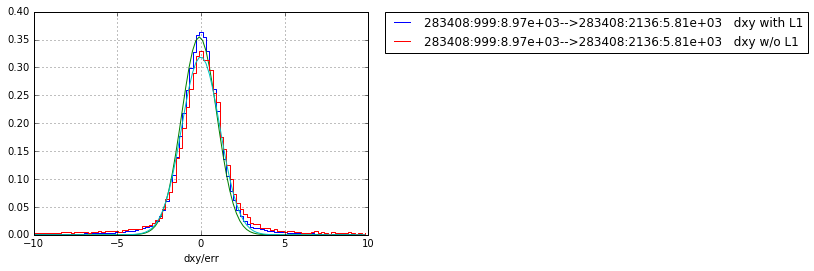

[ 0.35443101 -0.09950756  1.0558192 ]
[ 0.32754564 -0.08872271  1.12773924]


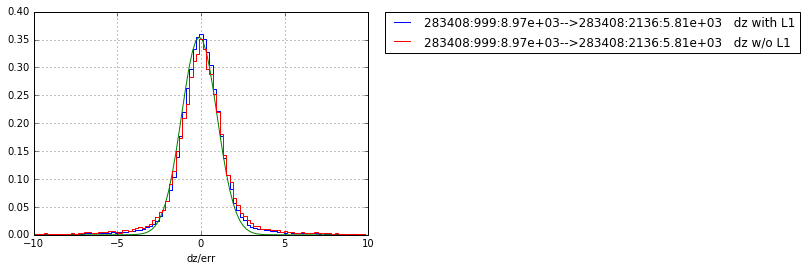

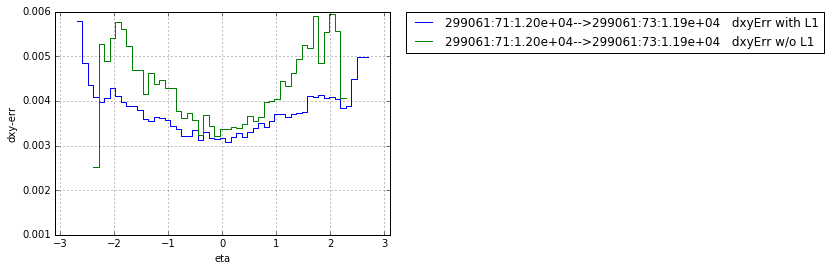

[ 0.4397476  -0.15600548  0.79813234]
[ 0.39465778 -0.1335686   0.86652254]


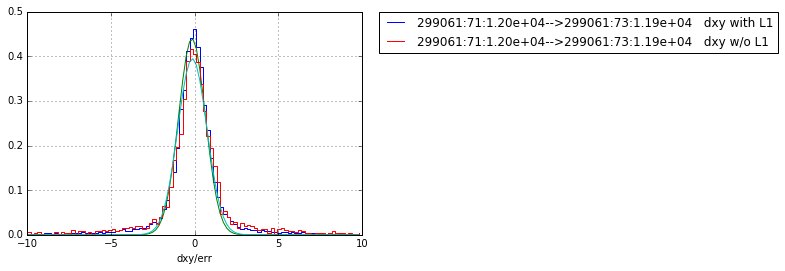

[ 0.40762814 -0.09439469  0.83250411]
[ 0.39116368 -0.04756216  0.89016637]


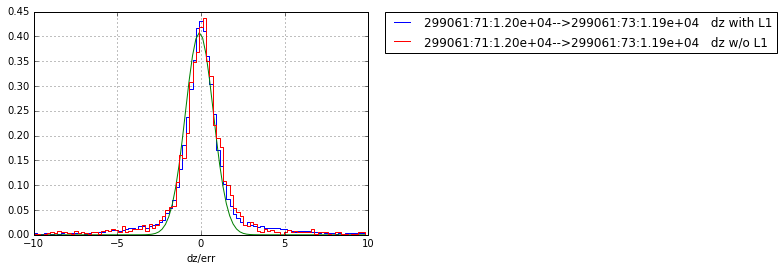

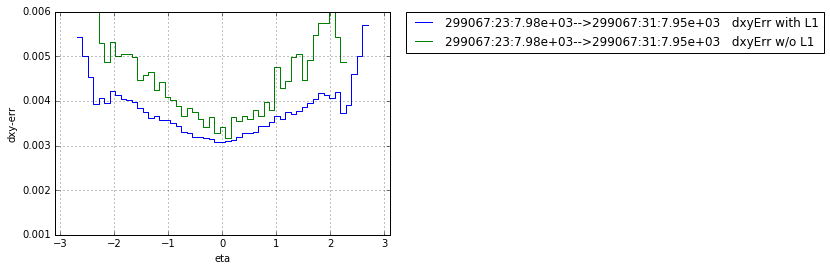

[ 0.44922197 -0.15402536  0.78056092]
[ 0.39173605 -0.19758558  0.86862737]


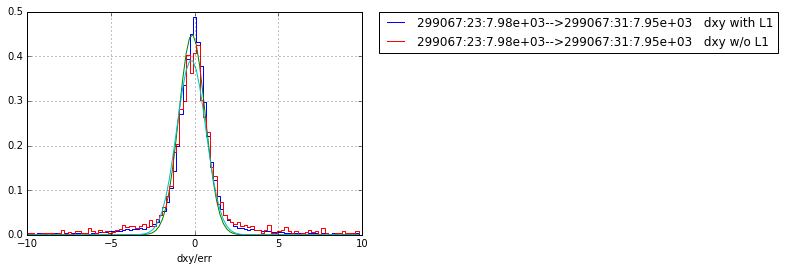

[ 0.41991661 -0.08807799  0.82421365]
[ 0.39063481 -0.05904389  0.89251327]


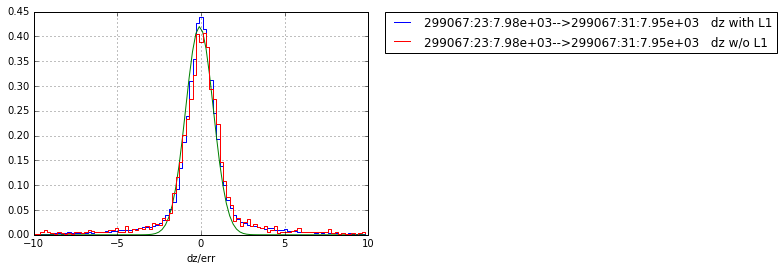

In [41]:
i=0
for b in sipH:
    plt.step(b[5],b[6],where='post',label=runid0[i]+'   dxyErr with L1')
    plt.step(b[5],b[7],where='post',label=runid0[i]+'   dxyErr w/o L1')
    plt.xlim(-3.1, 3.1)
    plt.ylim(0.001, 0.006)
    plt.grid(True)
    plt.ylabel('dxy-err')
    plt.xlabel('eta')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#    plt.legend(loc='upper right')
    plt.show()
    
    plt.step(b[0],b[1],where='post',label=runid0[i]+'   dxy with L1')
    out   = leastsq( errfunc, init, args=(b[0][30:70], b[1][30:70]))
    c = out[0]
    print c
    plt.plot(b[0], fitfunc(c, b[0]))
    plt.step(b[0],b[3],where='post',label=runid0[i]+'   dxy w/o L1')
    out   = leastsq( errfunc, init, args=(b[0][30:70], b[3][30:70]))
    c = out[0]
    print c
    plt.plot(b[0], fitfunc(c, b[0]))
    plt.xlim(-10., 10.)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#    plt.legend(loc='upper right')
    plt.xlabel('dxy/err')
#    i+=1
    plt.show()

    plt.step(b[0],b[2],where='post',label=runid0[i]+'   dz with L1')
    out   = leastsq( errfunc, init, args=(b[0][30:70], b[2][30:70]))
    c = out[0]
    print c
    plt.plot(b[0], fitfunc(c, b[0]))
    plt.step(b[0],b[4],where='post',label=runid0[i]+'   dz w/o L1')
    out   = leastsq( errfunc, init, args=(b[0][30:70], b[4][30:70]))
    c = out[0]
    print c
    plt.xlim(-10., 10.)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#    plt.legend(loc='upper right')
    plt.xlabel('dz/err')
    i+=1
    plt.show()




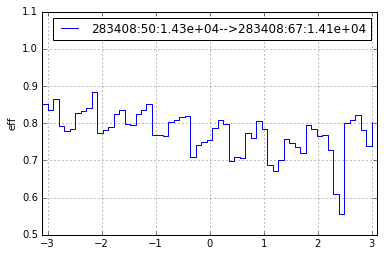

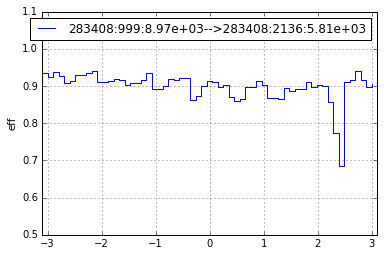

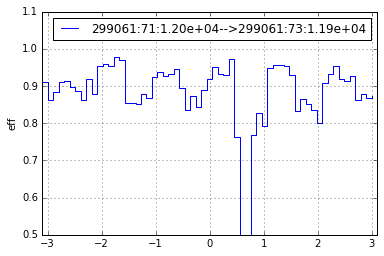

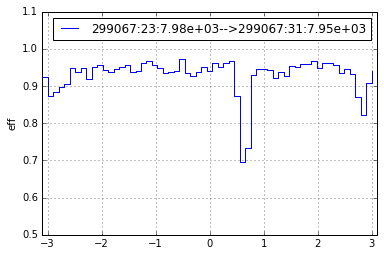

In [39]:
i=0
for b in effH:
    plt.step(b[0],b[1],where='post',label=runid0[i])
    plt.xlim(-3.1, 3.1)
    plt.ylim(0.5, 1.1)
    plt.grid(True)
#    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.legend(loc='upper right')
    plt.ylabel('eff')
    i+=1
    plt.show()
